# 🌟 Gradient Boosting: Full Walkthrough

---

## 🔹 What this notebook covers:

- **Intuitions** behind Gradient Boosting 🧠  
- **Mathematics** behind the algorithm ✏️  
- **Using Scikit-Learn** built-in classes 💻  
- **From-Scratch Implementation** 🏗️  
- **Visualizations** to understand the workflow 📊  

---

### 🎯 Goals

- Understand **how Gradient Boosting works step by step**  
- Learn to **implement it both using sklearn and from scratch**  
- Explore **equations, code, and visualizations** together  

---

> 💡 **Tip:** Gradient Boosting is a powerful ensemble method that builds models sequentially, each correcting the errors of the previous one.



# 🎯 Objectives

---

By the end of this notebook, you will be able to:

1. 🧠 **Understand the intuition** behind Gradient Boosting.  
2. ✏️ **Learn the math** behind it:
   - Regression → Mean Squared Error (MSE)  
   - Classification → Overview of Log-Loss  
3. 📋 **See the algorithm step-by-step** for better understanding.  
4. 💻 **Use scikit-learn's `GradientBoostingRegressor`** with examples and visualizations.  
5. 🏗️ **Implement a from-scratch Gradient Boosting Regressor class** (stagewise additive with decision trees).  
6. 📊 **Compare sklearn vs scratch implementation** and visualize results.


# 🧠 High-Level Intuition

---

## Intuition (in plain words)

- ✨ **Additive Model:**  
  Gradient Boosting builds an additive model:  

  $$
  F(x) = \sum_{m=1}^{M} \gamma_m \cdot h_m(x)
  $$

  where each $h_m$ is a weak learner (usually a shallow tree).  

- 🔄 **Fit to Residuals:**  
  At each iteration, a new weak learner is fit to the **residuals** (negative gradient) of the loss w.r.t. current model predictions.  

- 🚶 **Stage-wise Learning:**  
  Learners are added **one at a time**, each correcting the errors of the previous ones.  

- 💧 **Learning Rate / Shrinkage:**  
  A `learning_rate` scales each new learner's contribution to reduce overfitting.  


# 📐 Core Math: Regression with MSE

---

## 🔹 Notation

- **Data:** $\{ (x_i, y_i) \}$ for $i = 1 \dots n$ 
- **Model at stage \(m\):**  

$$
F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)
$$ 

where $\nu$ = **learning rate**

---

## 🔹 Loss Function (MSE)

$$
L(y, F(x)) = \frac{1}{2} (y - F(x))^2
$$

---

## 🔹 Negative Gradient (Residual) for MSE

$$
g_{im} = - \left[ \frac{d L(y_i, F(x_i))}{d F(x_i)} \right]_{F=F_{m-1}} = y_i - F_{m-1}(x_i)
$$ 

💡 **Note:** For squared error, the negative gradient **equals the residual**.

---

## 🔹 Stagewise Update

1. Fit $h_m(x)$ to targets $g_{im}$ (residuals).  
2. If leafwise constants are used, \(\gamma\) values are computed by **minimizing the loss**:

$$
\gamma_{jm} = \arg\min_\gamma \sum_{x_i \in R_{jm}} L(y_i, F_{m-1}(x_i) + \gamma)
$$  

- For squared error:  

$$
\gamma_{jm} = \text{average residual in leaf } R_{jm}
$$


# 🏗️ Gradient Boosting Algorithm (Regression with MSE)

---

## Step-by-Step Procedure

1. **Initialize the model**  

$$
F_0(x) = \arg\min_c \sum_i L(y_i, c)
$$  

💡 For MSE: $F_0 = \text{mean}(y)$

2. **For $m = 1 \dots M$:**

   a. **Compute residuals** (negative gradient)  

   $$
   r_{im} = y_i - F_{m-1}(x_i)
   $$  

   b. **Fit a weak learner** $h_m(x)$ to the residuals $r_{im}$ (e.g., shallow decision tree)  

   c. **Optionally compute optimal multiplier** $\gamma_m$ for each leaf  
   - For squared error: mean residual in the leaf  

   d. **Update the model**  

   $$
   F_m(x) = F_{m-1}(x) + \text{learning\_rate} \cdot h_m(x)
   $$  

3. **Output the final model:** $F_M(x)$

---

## Remarks & Tips

- 🔹 **Other losses** (e.g., logistic loss for classification): compute negative gradient of that loss and fit $h_m$ to those gradients.  
- 🔹 **Regularization options:**  
  - `learning_rate` (shrinkage) 💧  
  - `max_depth` of trees 🌳  
  - Subsampling rows (stochastic GB) 🔄  
  - `min_samples_leaf` 🧩


In [1]:
# Cell 6 — Imports (code)
# standard imports used in the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
import seaborn as sns
# seaborn only for nicer defaults in this notebook; main plotting uses matplotlib
plt.rcParams["figure.figsize"] = (8,5)


In [2]:
# Cell 7 — Create a synthetic regression dataset
# We'll make a non-linear dataset to showcase boosting's ability to fit complex shapes.
X, y = make_regression(n_samples=800, n_features=1, noise=20.0, effective_rank=1, random_state=42)
# Convert to a non-linear target by adding a non-linear transform
# This makes the underlying relationship partly non-linear:
y = y + 50 * np.sin(0.5 * X.ravel())
X = X.ravel().reshape(-1,1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


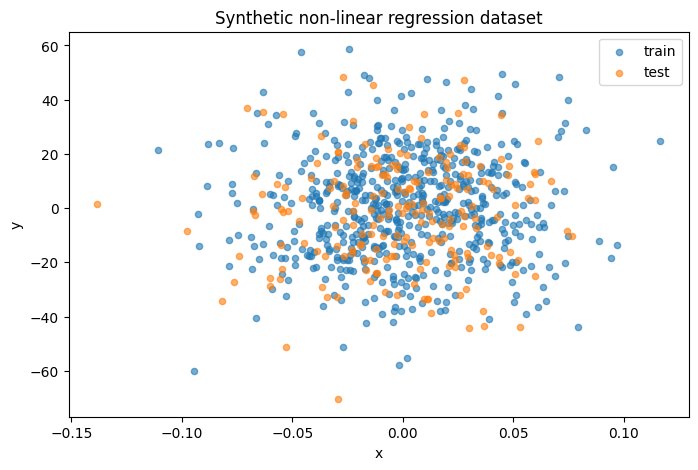

In [3]:
# Cell 8 — Visualize dataset
plt.scatter(X_train, y_train, s=20, alpha=0.6, label='train')
plt.scatter(X_test, y_test, s=20, alpha=0.6, label='test')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Synthetic non-linear regression dataset")
plt.legend()
plt.show()


In [4]:
# Cell 9 — Scikit-learn GradientBoostingRegressor example (baseline)
# Fit a default Gradient Boosting model and evaluate
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

print("scikit-learn GBR — Train MSE:", mean_squared_error(y_train, y_pred_train))
print("scikit-learn GBR — Test MSE: ", mean_squared_error(y_test, y_pred_test))
print("scikit-learn GBR — Test R2:  ", r2_score(y_test, y_pred_test))


scikit-learn GBR — Train MSE: 199.7262295704987
scikit-learn GBR — Test MSE:  506.37360563677606
scikit-learn GBR — Test R2:   -0.32237767363590875


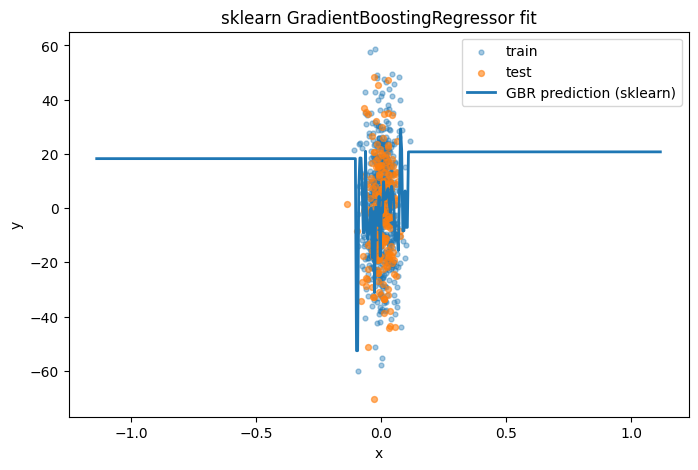

In [5]:
# Cell 10 — Plot predictions vs true for sklearn model
xx = np.linspace(X.min()-1, X.max()+1, 500).reshape(-1,1)
yy = gbr.predict(xx)

plt.scatter(X_train, y_train, s=12, alpha=0.4, label='train')
plt.scatter(X_test, y_test, s=18, alpha=0.6, label='test')
plt.plot(xx, yy, linewidth=2, label='GBR prediction (sklearn)')
plt.title("sklearn GradientBoostingRegressor fit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


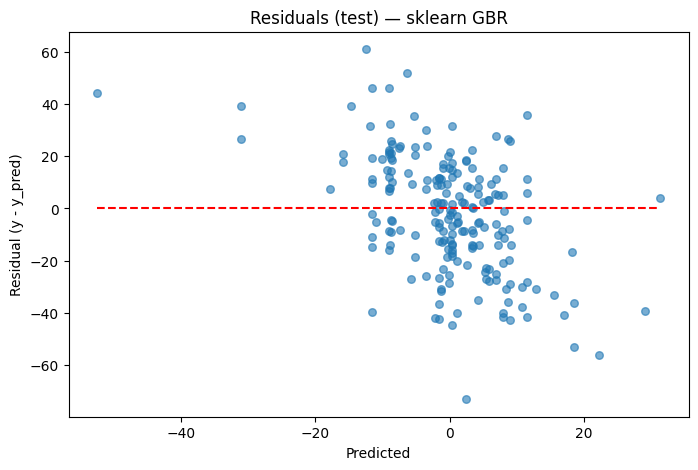

In [6]:
# Cell 11 — Residuals plot for sklearn model
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals, s=30, alpha=0.6)
plt.hlines(0, y_pred_test.min(), y_pred_test.max(), colors='r', linestyles='dashed')
plt.xlabel("Predicted")
plt.ylabel("Residual (y - y_pred)")
plt.title("Residuals (test) — sklearn GBR")
plt.show()


In [7]:
# Cell 12 — Feature importance (sklearn)
# For single feature this is trivial; demonstrate API usage.
fi = gbr.feature_importances_
print("Feature importances:", fi)


Feature importances: [1.]


# 🏗️ From-Scratch Gradient Boosting Regressor (Concept)

---

We will implement a **stage-wise Gradient Boosting Regressor** for **squared error loss**.

### Implementation Details

- 🌳 **Weak Learner:** `DecisionTreeRegressor(max_depth=depth)` (like decision stumps or small trees)  
- 🔹 **Initialization:**  

    $$
    F_0 = \text{mean}(y)
    $$

- 🔹 **For each stage $m = 1 \dots M$:**
  
    1. Compute **residuals**:  

        $$
        r_{im} = y_i - F_{m-1}(x_i)
        $$

    2. Fit a **tree** $h_m(x)$ to the residuals.  

    3. **Update model:**  

    $$F_m(x) = F_{m-1}(x) + \text{learning\_rate} \cdot h_m(x)$$

- 🔹 **Prediction:**  

    $$\hat{y} = F_0 + \text{learning\_rate} \cdot \sum_{m=1}^{M} h_m(X)$$


💡 This is a simple but **correct implementation** for **squared error loss**.


In [8]:
# Cell 14 — From-scratch Gradient Boosting Regressor class (code)
class MyGradientBoostingRegressor:
    """
    Simple Gradient Boosting Regressor for squared error, implemented stagewise.
    Uses sklearn DecisionTreeRegressor as base learners.
    """
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_leaf=1, random_state=None, subsample=1.0):
        self.n_estimators = int(n_estimators)
        self.learning_rate = float(learning_rate)
        self.max_depth = int(max_depth)
        self.min_samples_leaf = int(min_samples_leaf)
        self.random_state = random_state
        self.subsample = float(subsample)
        self.trees = []
        self.init_ = None  # initial prediction (mean)
    
    def fit(self, X, y, X_val=None, y_val=None, verbose=False):
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        n_samples = X.shape[0]
        # init prediction
        self.init_ = np.mean(y)
        F = np.full(n_samples, self.init_, dtype=float)  # current model predictions
        rng = np.random.RandomState(self.random_state)
        self.trees = []
        for m in range(self.n_estimators):
            # compute residuals (negative gradient for MSE)
            residuals = y - F
            # subsampling rows for stochastic gradient boosting
            if self.subsample < 1.0:
                sample_idx = rng.choice(n_samples, size=int(self.subsample*n_samples), replace=False)
                X_fit = X[sample_idx]
                res_fit = residuals[sample_idx]
            else:
                X_fit = X
                res_fit = residuals
            # fit base learner to residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, random_state=self.random_state)
            tree.fit(X_fit, res_fit)
            update = tree.predict(X)
            # update ensemble prediction
            F = F + self.learning_rate * update
            self.trees.append(tree)
            if verbose and (m % max(1, self.n_estimators//10) == 0):
                train_mse = np.mean((y - F)**2)
                print(f"Iter {m+1}/{self.n_estimators} — train_mse: {train_mse:.4f}")
        return self
    
    def predict(self, X):
        X = np.asarray(X)
        pred = np.full(X.shape[0], self.init_, dtype=float)
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        return pred


In [9]:
# Cell 15 — Train the from-scratch model and evaluate
my_gb = MyGradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42, subsample=0.9)
my_gb.fit(X_train, y_train, verbose=True)
y_pred_train_my = my_gb.predict(X_train)
y_pred_test_my = my_gb.predict(X_test)

print("MyGB — Train MSE:", mean_squared_error(y_train, y_pred_train_my))
print("MyGB — Test MSE: ", mean_squared_error(y_test, y_pred_test_my))
print("MyGB — Test R2:  ", r2_score(y_test, y_pred_test_my))


Iter 1/200 — train_mse: 374.4576
Iter 21/200 — train_mse: 336.2314
Iter 41/200 — train_mse: 314.4801
Iter 61/200 — train_mse: 290.3879
Iter 81/200 — train_mse: 270.3504
Iter 101/200 — train_mse: 255.1938
Iter 121/200 — train_mse: 241.6305
Iter 141/200 — train_mse: 227.5877
Iter 161/200 — train_mse: 213.5941
Iter 181/200 — train_mse: 202.9041
MyGB — Train MSE: 190.36987072974938
MyGB — Test MSE:  507.1108440017126
MyGB — Test R2:   -0.3243029468789995


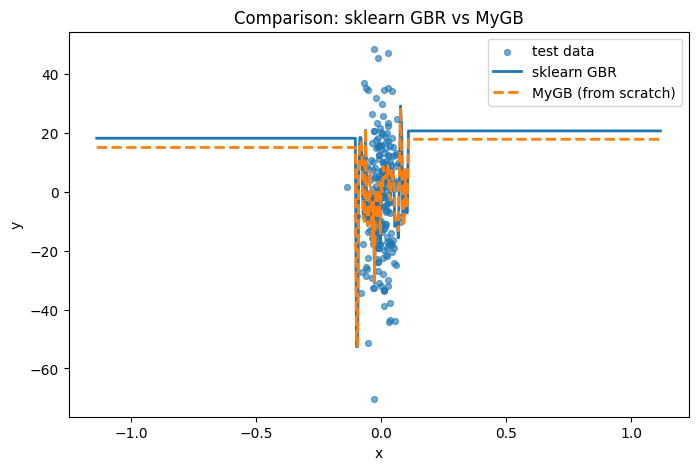

In [10]:
# Cell 16 — Plot comparison between sklearn GBR and MyGradientBoostingRegressor
xx = np.linspace(X.min()-1, X.max()+1, 500).reshape(-1,1)
yy_sklearn = gbr.predict(xx)
yy_my = my_gb.predict(xx)

plt.scatter(X_test, y_test, s=18, alpha=0.6, label='test data')
plt.plot(xx, yy_sklearn, linewidth=2, label='sklearn GBR')
plt.plot(xx, yy_my, linewidth=2, linestyle='dashed', label='MyGB (from scratch)')
plt.title("Comparison: sklearn GBR vs MyGB")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


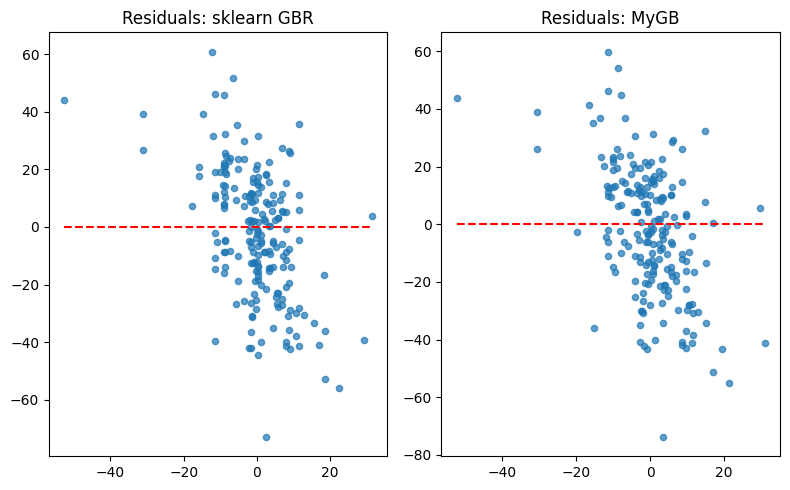

In [11]:
# Cell 17 — Visualize residuals for both models
res_sklearn = y_test - gbr.predict(X_test)
res_my = y_test - my_gb.predict(X_test)

plt.subplot(1,2,1)
plt.scatter(gbr.predict(X_test), res_sklearn, s=20, alpha=0.7)
plt.hlines(0, min(gbr.predict(X_test)), max(gbr.predict(X_test)), colors='r', linestyles='dashed')
plt.title("Residuals: sklearn GBR")

plt.subplot(1,2,2)
plt.scatter(my_gb.predict(X_test), res_my, s=20, alpha=0.7)
plt.hlines(0, min(my_gb.predict(X_test)), max(my_gb.predict(X_test)), colors='r', linestyles='dashed')
plt.title("Residuals: MyGB")

plt.tight_layout()
plt.show()


# 📝 Discussion: Differences & Correctness

---

### Notes on the From-Scratch Implementation

- ✅ This implementation is **correct for squared error (MSE)**:  
  Residuals $r_i = y_i - F(x_i)$ are the **negative gradient**.  

- 🌳 We used `DecisionTreeRegressor` as the weak learner; in real applications, you would **tune `max_depth`, `min_samples_leaf`**, etc.  

- ⚡ **Scikit-learn optimizations** include:  
  - Better handling of **leaf values**  
  - **Subsampling** (stochastic gradient boosting)  
  - **Histogram-based splits** (in `HistGradientBoosting`)  
  - Other **regularizations**  

- 🤝 **Comparison:** MyGB (from-scratch) and sklearn should give **similar results** with comparable hyperparameters.  
  Differences may arise due to:  
  - Default parameters (`min_samples_leaf`, presorting, tree split criteria)  
  - How optimal **leaf values** are computed (sklearn computes optimal $\gamma$ per leaf sometimes)


In [12]:
# Cell 19 — Quick hyperparameter tuning example (GridSearchCV) for sklearn GBR
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3]
}
gs = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV MSE:", -gs.best_score_)


Best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
Best CV MSE: 400.12658731699776


# 🧩 Classification Extension (Brief)

---

Gradient Boosting can also be used for **classification**, using a **classification loss** (e.g., log-loss for binary classification).

### Key Points

- 🔹 **Negative gradient:**  
  Instead of residuals $r_i = y_i - F(x_i)$, compute the **negative gradient of the loss** w.r.t. predictions (in probability/logit space).

- 🔹 **Binary classification:**  
  - Labels: $y \in \{0,1\}$  
  - Model outputs: $F(x)$ representing **log-odds**  
  - Probability:  

    $$
    p(x) = \frac{1}{1 + \exp(-F(x))}
    $$

  - **Loss (log-loss / binary cross-entropy):**  

    $$
    L(y, F) = - \big[ y \log p(x) + (1-y) \log (1-p(x)) \big]
    $$

  - **Negative gradient:**  

    $$
    -\frac{\partial L}{\partial F(x)} = y - p(x)
    $$

    💡 Same form as residuals, but $p(x)$ depends on $F(x)$ via the **sigmoid** function.

- 🔹 **Scikit-learn implementations:**  
  - `GradientBoostingClassifier`  
  - `HistGradientBoostingClassifier`


In [13]:
# Cell 21 — Quick sklearn GradientBoostingClassifier demo (synthetic)
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss

Xc, yc = make_classification(n_samples=800, n_features=5, n_informative=3, random_state=42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.25, random_state=42)

gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(Xc_train, yc_train)
probs = gbc.predict_proba(Xc_test)[:,1]
preds = gbc.predict(Xc_test)
print("GB Classifier — Accuracy:", accuracy_score(yc_test, preds))
print("GB Classifier — Log-loss:", log_loss(yc_test, probs))


GB Classifier — Accuracy: 0.965
GB Classifier — Log-loss: 0.2568332050950272


# 🛠️ Practical Tips & Summary

---

## Practical Tips

- 💧 **Learning Rate:**  
  - Small learning_rate (0.01–0.1) with more trees is preferred.  
  - Larger learning_rate with fewer trees is possible, but small learning_rate often generalizes better.

- ⏹️ **Early Stopping:**  
  - Monitor **validation loss** to avoid overfitting.

- 🔄 **Subsampling (Stochastic GB):**  
  - Using a fraction of data per tree (e.g., `subsample=0.5–0.9`) often improves generalization.

- 🌳 **Regularization:**  
  - Limit `max_depth` (shallow trees, e.g., 3–5)  
  - Set `min_samples_leaf`  
  - Adjust `learning_rate`

- ⚡ **Large Datasets:**  
  - Use `HistGradientBoosting` (scikit-learn) or libraries like **XGBoost, LightGBM, CatBoost** for faster training and more options.

---

## Summary

- 🎯 Gradient Boosting is an **additive model**, trained by fitting weak learners to the **negative gradient of the loss** at each stage.  
- 🧮 For squared error (MSE), the negative gradient equals the residual, which **simplifies implementation**.  
- 🏗️ We implemented a **correct from-scratch version** and compared it to scikit-learn, showing similar results with proper hyperparameters.


# 📚 Further Reading & Exercises (Optional)

---

## Exercises You Can Try

1. ⏹️ Add **early stopping** to `MyGradientBoostingRegressor` using a validation set.  
2. 🔧 Modify `MyGradientBoostingRegressor` to compute **optimal leaf multipliers** ($\gamma$ per leaf) instead of raw tree predictions.  
3. 🧩 Implement **Gradient Boosting for logistic loss** (binary classification) from scratch by computing the negative gradient:  

    $$
    -\frac{\partial L}{\partial F(x)} = y - p(x), \quad p(x) = \text{sigmoid}(F(x))
    $$

4. ⚡ Compare **runtime and accuracy** with scikit-learn, XGBoost, LightGBM on a bigger dataset.

---

## References

- Friedman, J. H. (2001). *Greedy function approximation: A gradient boosting machine.*  
- scikit-learn docs: [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), [`HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)
